<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/01_pytorch_workflow_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Exercise Template

The following is a template for the PyTorch workflow exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [1]:
# Import necessary libraries
import torch
import matplotlib.pyplot as plt
from torch import nn

In [2]:
# Setup device-agnostic code
try:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using device: {device}')
    
except RuntimeError as e:
    print(f'{e}')

Using device: cuda


## 1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).
  * Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total. 
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.

Your output of the below cell should look something like:
```
Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900])
y: tensor([0.9000, 0.9030, 0.9060, 0.9090, 0.9120, 0.9150, 0.9180, 0.9210, 0.9240,
        0.9270])
```

Of course the numbers in `X` and `y` may be different but ideally they're created using the linear regression formula.

In [3]:
# Create the data parameters
weight = 0.3
bias = 0.9
start = 0
end = 1
step = 0.01

# Make X and y using linear regression feature
X = torch.arange(start, end, step, device=device).unsqueeze(dim=1)
y = weight * X + bias

print(f'Number of X samples: {len(X)}')
print(f'Number of y samples: {len(y)}')
print(f'First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}')

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]], device='cuda:0')
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]], device='cuda:0')


In [4]:
# Split the data into training and testing
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [5]:
# Plot the training and testing data 
# Función para graficar los subconjuntos y las predicciones
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None
):
    plt.style.use('dark_background')
    plt.figure(figsize=(9, 5))
    plt.scatter(train_data, train_labels, c='steelblue', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='darkgreen', s=4, label='Testing data')
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c='crimson', s=4, label='Predictions')
        
    plt.legend(prop={'size': 10})
    plt.grid(color='white', linestyle='-', linewidth=0.25)
    plt.tight_layout()

## 2. Build a PyTorch model by subclassing `nn.Module`. 
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`. 
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1. 
  * Once you've constructed the model, make an instance of it and check its `state_dict()`.
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [6]:
# Create PyTorch linear regression model by subclassing nn.Module
# Construir el modelo
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear_layer = nn.Linear(in_features=X_train.shape[1],
                                      out_features=y_train.shape[1],
                                      device=device)
    
    # Es la función de nuestro modelo para nuestro caso como estamos usando una regresión lineal
    def forward(self, X: torch.Tensor) -> torch.Tensor: # X son los datos de entrada
        return self.linear_layer(X) # Formula de la regresión lineal

In [7]:
# Instantiate the model and put it to the target device
torch.manual_seed(42)
model = LinearRegressionModel()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.2259]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.9754], device='cuda:0'))])

## 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively. 
  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.

In [8]:
# Create the loss function and optimizer
loss_fn = nn.L1Loss() # MAE
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [9]:
# Training loop

# Train model for 300 epochs
epochs = 300

for epoch in range(epochs + 1):
  ### Training

  # Put model in train mode
  model.train()

  # 1. Forward pass
  outputs = model.forward(X_train)

  # 2. Calculate loss
  loss = loss_fn(input=outputs, target=y_train)

  # 3. Zero gradients
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Perform testing every 20 epochs
  if epoch % 20 == 0:

    # Put model in evaluation mode and setup inference context
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model.forward(X_test)
      
      # 2. Calculate test loss
      test_loss = loss_fn(test_pred, y_test) 

      # Print out what's happening
      print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Test loss: {test_loss:.3f}")

Epoch: 0 | Train loss: 0.046 | Test loss: 0.005
Epoch: 20 | Train loss: 0.012 | Test loss: 0.027
Epoch: 40 | Train loss: 0.005 | Test loss: 0.011
Epoch: 60 | Train loss: 0.005 | Test loss: 0.005
Epoch: 80 | Train loss: 0.005 | Test loss: 0.005
Epoch: 100 | Train loss: 0.005 | Test loss: 0.005
Epoch: 120 | Train loss: 0.005 | Test loss: 0.005
Epoch: 140 | Train loss: 0.005 | Test loss: 0.005
Epoch: 160 | Train loss: 0.005 | Test loss: 0.005
Epoch: 180 | Train loss: 0.005 | Test loss: 0.005
Epoch: 200 | Train loss: 0.005 | Test loss: 0.005
Epoch: 220 | Train loss: 0.005 | Test loss: 0.005
Epoch: 240 | Train loss: 0.005 | Test loss: 0.005
Epoch: 260 | Train loss: 0.005 | Test loss: 0.005
Epoch: 280 | Train loss: 0.005 | Test loss: 0.005
Epoch: 300 | Train loss: 0.005 | Test loss: 0.005


## 4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [10]:
# Make predictions with the model
with torch.inference_mode():
    y_preds = model.forward(X_test)

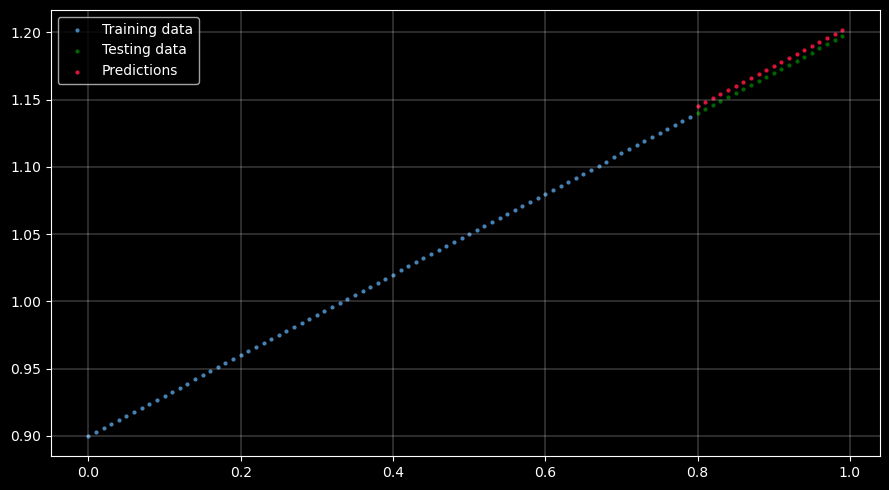

In [11]:
# Plot the predictions (these may need to be on a specific device)
plot_predictions(
    train_data=X_train.cpu(),
    train_labels=y_train.cpu(),
    test_data=X_test.cpu(),
    test_labels=y_test.cpu(),
    predictions=y_preds.cpu()
)

## 5. Save your trained model's `state_dict()` to file.
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [12]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = 'model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f'Saving: {MODEL_SAVE_PATH}')
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving: models\model.pth


In [13]:
# Create new instance of model and load saved state dict (make sure to put it on the target device)
loaded_model = LinearRegressionModel()

# Cargamos los parámetros actualizados del modelo
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [14]:
# Make predictions with loaded model and compare them to the previous
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model.forward(X_test)

loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')